In [1]:
!git clone https://github.com/openai/multiagent-particle-envs.git

Cloning into 'multiagent-particle-envs'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 242 (delta 0), reused 3 (delta 0), pack-reused 237
Receiving objects: 100% (242/242), 107.24 KiB | 3.83 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [2]:
cd multiagent-particle-envs

/content/multiagent-particle-envs


In [3]:
pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/multiagent-particle-envs
  Running setup.py develop for multiagent


In [4]:
pip install gym==0.10.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 4.0 MB/s 
  Created wheel for gym: filename=gym-0.10.5-py3-none-any.whl size=1581307 sha256=4f34e7f6c0484b294c2b040a4b413d1858ec3759b7cbf091cbfbd749b29ede8e
  Stored in directory: /root/.cache/pip/wheels/7a/2c/df/a05b548a40fae16ca400ecbeda0067e1a296499c1fbd7e0c9a
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import numpy as np
import csv
from make_env import make_env
import matplotlib.pyplot as plt
env = make_env("simple_reference")
import pickle as p
import os

In [6]:
class Actor(nn.Module):
  def __init__(self,state_size,action_size):
    super(Actor,self).__init__()
    self.state_size = state_size
    self.action_size = action_size
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,128)
    self.fc4 = nn.Linear(128,512)
    self.fc5 = nn.Linear(512,128)
    self.fc6 = nn.Linear(128,self.action_size)
  def forward(self,x,i):
    if i ==0:
      L = self.state_size
    else:
      L = 11
    fc1 = nn.Linear(L,32)
    a1 = fc1(x)
    a2 = f.relu(self.fc5(f.relu(self.fc4(f.relu(self.fc3(f.relu(self.fc2(f.relu(a1)))))))))
    a3 = f.softmax(self.fc6(a2))
    return a3
class Critic(nn.Module):
  def __init__(self,state_size,action_size,reward_size):
    super(Critic,self).__init__()
    self.state_size,self.action_size ,self.reward_size = state_size,action_size,reward_size
    self.fac    = nn.Linear(self.action_size,32)
    self.frc    = nn.Linear(self.reward_size,32)
    self.fc3    = nn.Linear(64,128)
    self.fc4    = nn.Linear(128,512)
    self.fc5    = nn.Linear(512,128)
    self.fc6    = nn.Linear(128,1)
  def forward(self,s,a,r,i):
    if i ==0:
      L = self.state_size
    else:
      L = 11
    fc1    = nn.Linear(L,32)
    a1     = fc1(s)
    a2     = self.fac(a)
    a3     = self.frc(r)
    x      = torch.cat([a1.view(32,-1),a2.view(32,-1),a3.view(32,-1)])
    x      = torch.reshape(x,(-1,))
    fc2    = nn.Linear(x.shape[0],64)
    f1     = f.relu(self.fc5(f.relu(self.fc4(f.relu(self.fc3(f.relu(fc2(f.relu(x)))))))))
    f2     = self.fc6(f1)
    return f2
class Central(nn.Module):
  def __init__(self,state_size,action_size,reward_size):
    super(Central,self).__init__()
    self.state_size,self.action_size ,self.reward_size = state_size,action_size,reward_size
    self.fac    = nn.Linear(self.action_size,32)
    self.frc    = nn.Linear(self.reward_size,32)
    self.fc3    = nn.Linear(64,128)
    self.fc4    = nn.Linear(128,512)
    self.fc5    = nn.Linear(512,128)
    self.fc6    = nn.Linear(128,1)
  def forward(self,s,a,r,i):
    if i ==0:
      L = self.state_size
    else:
      L = 11
    fc1    = nn.Linear(L,32)
    a1     = fc1(s)
    a2     = self.fac(a)
    a3     = self.frc(r)
    x      = torch.cat([a1.view(32,-1),a2.view(32,-1),a3.view(32,-1)])
    x      = torch.reshape(x,(-1,))
    fc2    = nn.Linear(x.shape[0],64)
    f1     = f.relu(self.fc5(f.relu(self.fc4(f.relu(self.fc3(f.relu(fc2(f.relu(x)))))))))
    f2     = self.fc6(f1)
    return f2

In [7]:
class Buffer:
  def __init__(self):
    self.agent1_reward        = []
    self.agent2_reward        = []
    self.agent1_mean          = []
    self.agent2_mean          = []
    self.agent1_value         = []
    self.agent1_next_value    = []
    self.agent2_value         = []
    self.agent2_next_value    = []
    self.agent1_state         = []
    self.agent2_state         = []
    self.agent1_next_state    = []
    self.agent2_next_state    = []
    self.agent1_loss          = []
    self.agent2_loss          = []
    self.agent1_returns       = []
    self.agent2_returns       = []
    self.agent1_main_returns  = []
    self.agent2_main_returns  = []
    self.agent1_mean_returns  = []
    self.agent2_mean_returns  = []
    self.agent1_mean_loss     = []
    self.agent2_mean_loss     = []
    self.agent1_log_prob      = []
    self.agent2_log_prob      = []
    self.agent1_log_prob_mean = []
    self.agent1_next_log_probm= []
    self.agent1_next_log_prob = []
    self.agent2_next_log_prob = []
    self.agent2_log_prob_mean = []
    self.agent2_next_log_probm= []
    self.agent1_value_mean    = []
    self.agent2_value_mean    = []
    self.agent1_next_value_m  = []
    self.agent2_next_value_m  = []
    self.cc_value             = []
    self.cc_state             = []
    self.cc_next_state        = []
    self.cc_next_value        = []
    self.cc_loss              = []
    self.cc_mean_loss         = []
    self.cc_returns           = []
    self.episodes             = []
    self.cc_mean_value        = []


In [8]:
class Agent1:
  def __init__(self,state_size,action_size,reward_size,buffer):
    self.state_size = state_size
    self.action_size = action_size
    self.reward_size = reward_size
    self.gamma       = 0.99
    self.lamda       = 0.95
    self.lr1         = 0.00000000001
    self.lr2         = 0.00000000007
    self.buffer      = buffer
    self.device      = torch.device("cpu")
    self.actor       = Actor(self.state_size ,self.action_size).to(self.device)
    self.critic      = Critic(self.state_size,self.action_size,self.reward_size).to(self.device)
    self.actor_optim = optim.Adam(self.actor.parameters() , lr = self.lr1)
    self.critic_optim= optim.Adam(self.critic.parameters() ,lr = self.lr2)
    self.path        = ["Agent1_Actor.pth","Agent1_Critic.pth"]

  def rand(self):
    ar = np.random.uniform(0.171,0.219,1)[0]
    br = np.random.uniform(0.189,0.215,1)[0]
    cr = np.random.uniform(0.189,0.215,1)[0]
    dr = np.random.uniform(0.181,0.219,1)[0]
    fr = np.random.uniform(0.181,0.219,1)[0]
    aa = torch.tensor([ar,br,cr,dr,fr],dtype = torch.float32)
    return aa
  def choose_action(self,state,i):
    state             = torch.tensor(state,dtype = torch.float32).to(self.device)
    rand              = self.rand()
    act               = self.actor(state,i).to(self.device)
    action            = act + rand
    return action.detach().numpy()
  def q_value(self,state,action,reward,i):
    reward            = torch.tensor([reward , 0],dtype = torch.float32).to(self.device)
    action            = torch.tensor(action,dtype = torch.float32).to(self.device)
    q_value           = self.critic(state,action,reward,i).to(self.device)
    return q_value
  def get_gae(self,reward,d,value,next_value):
    returns  = []
    gae      = 0
    reward   = torch.tensor(reward,dtype = torch.float32).to(self.device)
    for i in range(5):
      delta  = reward + (1-d)*self.gamma*next_value -value
      gae    = delta + self.lamda * self.gamma*(1-d)*gae
      returns.insert(0,gae + value + next_value)
    return returns
  def appending(self,state,next_state,reward,value,loss,log_prob,next_log_prob,returns):
    self.buffer.agent1_loss.append(loss)
    self.buffer.agent1_state.append(state)
    self.buffer.agent1_next_state.append(next_state)
    self.buffer.agent1_value.append(value)
    self.buffer.agent1_log_prob.append(log_prob)
    self.buffer.agent1_next_log_prob.append(next_log_prob)
    self.buffer.agent1_returns.append(returns)
    self.buffer.agent1_reward.append(reward)
    self.buffer.agent1_main_returns.append(returns)
  def learn(self,state,next_state,reward,next_value,done):
    state             = torch.from_numpy(state).float().to(self.device)
    next_state        = torch.from_numpy(next_state).float().to(self.device)
    action            = self.choose_action(state,0)
    next_action       = self.choose_action(next_state,1)
    log_prob          = torch.log(torch.tensor(action,dtype = torch.float32)).to(self.device)
    next_log_prob     = torch.log(torch.tensor(next_action,dtype = torch.float32)).to(self.device)
    value             = self.q_value(state,action,reward,0)
    next_value        = next_value
    ratio             = torch.exp(next_log_prob - log_prob)
    r                 = self.get_gae(reward,done,value,next_value)
    returns           = torch.tensor([r[0][0],r[1][0],r[2][0],r[3][0],r[4][0]])
    advantage         = returns + value + next_value
    s1                = ratio * advantage
    s2                = torch.clamp(ratio , 0.8,1.2)*advantage
    actor_loss        = torch.min(s1,s2).mean()
    critic_loss       = (returns - value).mean()**2
    loss              = actor_loss + critic_loss*0.5
    self.appending(state,next_state,reward,value,loss,log_prob,next_log_prob,returns)
    torch.save(self.actor,self.path[0])
    torch.save(self.critic ,self.path[1])
    self.actor_optim.zero_grad()
    self.critic_optim.zero_grad()
    loss.backward()
    self.actor_optim.step()
    self.critic_optim.step()

In [9]:
class Agent2:
  def __init__(self,state_size,action_size,reward_size,buffer):
    self.state_size = state_size
    self.action_size = action_size
    self.reward_size = reward_size
    self.gamma       = 0.99
    self.lamda       = 0.95
    self.lr1         = 0.00000000001
    self.lr2         = 0.00000000007
    self.buffer      = buffer
    self.device      = torch.device("cpu")
    self.actor       = Actor(self.state_size ,self.action_size).to(self.device)
    self.critic      = Critic(self.state_size,self.action_size,self.reward_size).to(self.device)
    self.actor_optim = optim.Adam(self.actor.parameters() , lr = self.lr1)
    self.critic_optim= optim.Adam(self.critic.parameters() ,lr = self.lr2)
    self.path        = ["Agent2_Actor.pth","Agent2_Critic.pth"]
  def rand(self):
    ar = np.random.uniform(0.171,0.219,1)[0]
    br = np.random.uniform(0.189,0.215,1)[0]
    cr = np.random.uniform(0.189,0.215,1)[0]
    dr = np.random.uniform(0.181,0.219,1)[0]
    fr = np.random.uniform(0.181,0.219,1)[0]
    aa = torch.tensor([ar,br,cr,dr,fr],dtype = torch.float32)
    return aa
  def choose_action(self,state,i):
    state             = torch.tensor(state,dtype = torch.float32).to(self.device)
    rand              = self.rand().to(self.device)
    act               = self.actor(state,i).to(self.device)
    action            = act + rand
    return action.detach().numpy()
  def q_value(self,state,action,reward,i):
    reward            = torch.tensor([reward , 0],dtype = torch.float32).to(self.device)
    action            = torch.tensor(action,dtype = torch.float32).to(self.device)
    q_value           = self.critic(state,action,reward,i).to(self.device)
    return q_value
  def get_gae(self,reward,d,value,next_value):
    returns  = []
    gae      = 0
    reward   = torch.tensor(reward,dtype = torch.float32).to(self.device)
    for i in range(5):
      delta  = reward + (1-d)*self.gamma*next_value -value
      gae    = delta + self.lamda * self.gamma*(1-d)*gae
      returns.insert(0,gae + value + next_value)
    return returns
  def appending(self,state,next_state,reward,value,log_prob,next_log_prob,loss,returns):
    self.buffer.agent2_state.append(state)
    self.buffer.agent2_next_state.append(next_state)
    self.buffer.agent2_reward.append(reward)
    self.buffer.agent2_value.append(value)
    self.buffer.agent2_log_prob.append(log_prob)
    self.buffer.agent2_next_log_prob.append(next_log_prob)
    self.buffer.agent2_loss.append(loss)
    self.buffer.agent2_returns.append(returns)
    self.buffer.agent2_main_returns.append(returns)
  def learn(self,state,next_state,reward,next_value,done):
    state             = torch.from_numpy(state).float().to(self.device)
    next_state        = torch.from_numpy(next_state).float().to(self.device)
    action            = self.choose_action(state,0)
    next_action       = self.choose_action(next_state,1)
    log_prob          = torch.log(torch.tensor(action,dtype = torch.float32)).to(self.device)
    next_log_prob     = torch.log(torch.tensor(next_action,dtype = torch.float32)).to(self.device)
    value             = self.q_value(state,action,reward,0)
    next_value        = next_value
    ratio             = torch.exp(next_log_prob - log_prob)
    r                 = self.get_gae(reward,done,value,next_value)
    returns           = torch.tensor([r[0][0],r[1][0],r[2][0],r[3][0],r[4][0]])
    advantage         = returns + value + next_value
    s1                = ratio * advantage
    s2                = torch.clamp(ratio , 0.8,1.2)*advantage
    actor_loss        = torch.min(s1,s2).mean()
    critic_loss       = (returns - value).mean()**2
    loss              = actor_loss + critic_loss*0.5
    self.appending(state,next_state,reward,value,loss,log_prob,next_log_prob,returns)
    torch.save(self.actor,self.path[0])
    torch.save(self.critic ,self.path[1])
    self.actor_optim.zero_grad()
    self.critic_optim.zero_grad()
    loss.backward()
    self.actor_optim.step()
    self.critic_optim.step()

In [13]:
import torch
import torch.optim as optim
import numpy as np
import pickle as p
import csv
import matplotlib.pyplot as plt
#from Network.network import Central
#from Agents.Agent1 import Agent1
#from Agents.Agent2 import Agent2
from make_env import make_env
env = make_env("simple_reference")

class Mappo:
  def __init__(self,state_size,action_size,reward_size,n_agents,n_games , step,buffer):
    self.state_size,self.action_size,self.reward_size = state_size,action_size,reward_size
    self.n_agents,self.n_games,self.step              = n_agents,n_games,step
    self.device      = torch.device("cpu")
    self.buffer      = buffer
    self.agent1      = Agent1(self.state_size,self.action_size,self.reward_size,self.buffer)
    self.agent2      = Agent2(self.state_size,self.action_size,self.reward_size,self.buffer)
    self.critic      = Central(self.state_size,self.action_size,self.reward_size).to(self.device)
    self.critic_optim= optim.Adam(self.critic.parameters() ,lr = 0.00000007)
    self.path        = ["central_critic.pth"]
  def choose_actions(self,state,i):
    actions   = []
    obs1      = torch.from_numpy(state[0]).float().to(self.device)
    obs2      = torch.from_numpy(state[1]).float().to(self.device)
    act1      = self.agent1.choose_action(obs1,i)
    act2      = self.agent2.choose_action(obs2,i)
    actions.append(act1)
    actions.append(act2)
    return actions
  def q_value(self,state,action,reward,i):
    state      = torch.from_numpy(state).float().to(self.device)
    action     = torch.tensor(action,dtype = torch.float32).to(self.device)
    reward     = torch.tensor([reward,0],dtype = torch.float32).to(self.device)
    q_value    = self.critic(state,action,reward,i).to(self.device)
    return q_value
  def appending(self,value,returns,g_state,g_next_state,loss):
    self.buffer.cc_loss.append(loss)
    self.buffer.cc_state.append(g_state)
    self.buffer.cc_next_state.append(g_next_state)
    self.buffer.cc_value.append(value)
    self.buffer.cc_returns.append(returns)
    self.buffer.agent1_returns = []
    self.buffer.agent2_returns = []
  def update(self,state,next_state,reward,done):
    g_state    = state[0] + state[1]
    g_next     = next_state[0] + next_state[1]
    g_reward   = reward[0] + reward[1]
    actions    = self.choose_actions(state,0)
    n_actions  = self.choose_actions(next_state,1)
    action     = actions[0]+[1]
    next_action= self.choose_actions(next_state,1)
    c_value    = self.q_value(g_state,action,g_reward,0)
    a1_nvalue  = self.q_value(next_state[0],n_actions[0],reward[0],1)
    a2_nvalue  = self.q_value(next_state[1],n_actions[1],reward[1],1)
    self.agent1.learn(state[0],next_state[0],reward[0],a1_nvalue,done[0])
    self.agent2.learn(state[1],next_state[1],reward[1],a2_nvalue,done[0])
    returnsa1  = self.buffer.agent1_returns[0].to(self.device)
    returnsa2  = self.buffer.agent2_returns[0].to(self.device)
    returns    = returnsa1/2+returnsa2/2
    loss       = (returns - c_value).mean()**2
    self.appending(c_value,returns,g_state,g_next,loss)
    torch.save(self.critic,self.path[0])
    self.critic_optim.zero_grad()
    loss.backward()
    self.critic_optim.step()
  def mean(self,i):
      self.buffer.agent1_mean.append(sum(self.buffer.agent1_reward)/len(self.buffer.agent1_reward))
      self.buffer.agent2_mean.append(sum(self.buffer.agent2_reward)/len(self.buffer.agent2_reward))
      self.buffer.agent1_mean_loss.append(sum(self.buffer.agent1_loss)/len(self.buffer.agent1_loss))
      self.buffer.agent2_mean_loss.append(sum(self.buffer.agent2_loss)/len(self.buffer.agent2_loss))
      self.buffer.agent1_mean_returns.append(sum(self.buffer.agent1_main_returns)/len(self.buffer.agent1_main_returns))
      self.buffer.agent2_mean_returns.append(sum(self.buffer.agent2_main_returns)/len(self.buffer.agent2_main_returns))
      self.buffer.agent1_mean_loss.append(sum(self.buffer.agent1_loss)/len(self.buffer.agent1_loss))
      self.buffer.agent2_mean_loss.append(sum(self.buffer.agent2_loss)/len(self.buffer.agent2_loss))
      self.buffer.cc_mean_loss.append(sum(self.buffer.cc_loss)/len(self.buffer.cc_loss))
      self.buffer.agent1_mean_returns.append(sum(self.buffer.agent1_main_returns)/len(self.buffer.agent1_main_returns))
      self.buffer.agent2_mean_returns.append(sum(self.buffer.agent2_main_returns)/len(self.buffer.agent2_main_returns))
      self.buffer.agent1_log_prob_mean.append(sum(self.buffer.agent1_log_prob)/len(self.buffer.agent1_log_prob))
      self.buffer.agent2_log_prob_mean.append(sum(self.buffer.agent2_log_prob)/len(self.buffer.agent2_log_prob))
      self.buffer.agent1_next_log_probm.append(sum(self.buffer.agent1_next_log_prob)/len(self.buffer.agent1_next_log_prob))
      self.buffer.agent2_next_log_probm.append(sum(self.buffer.agent2_next_log_prob)/len(self.buffer.agent2_next_log_prob))
      self.buffer.cc_mean_loss.append(sum(self.buffer.cc_loss)/len(self.buffer.cc_loss))
      self.buffer.cc_mean_value.append(sum(self.buffer.cc_value)/len(self.buffer.cc_value))
      self.buffer.episodes.append(i)
  def saving(self,m):
    l = []
    for i in range(len(self.buffer.agent1_mean)):
      l.append(i)
    st_line = ["slno","agent1_reward","agent2_reward","agent1_loss","agent2_loss","agent1_value","agent2_value","agent1_return","agent2_returns","agent1_log_prob","agent2_log_prob","agent1_next_log_prob","agent2_next_log_prob","centeral_value","central_loss"]
    with open("memory/multiagent.csv","w") as mcsv:
      write = csv.writer(mcsv)
      write.writerow([st_line[0],st_line[1],st_line[2],st_line[3],st_line[4],st_line[5],st_line[6],st_line[7],st_line[8],st_line[9],st_line[10],st_line[11],st_line[12],st_line[13],st_line[14]])
      write.writerow([l[m],self.buffer.agent1_mean[m],self.buffer.agent2_mean[m],self.buffer.agent1_mean_loss[m],self.buffer.agent2_mean_loss[m],self.buffer.agent1_value_mean[m],self.buffer.agent2_value_mean[m],self.buffer.agent1_mean_returns[m],self.buffer.agent2_mean_returns[m],self.buffer.agent1_log_prob_mean[m],self.buffer.agent2_log_prob_mean[m],self.buffer.agent1_next_log_probm[m],self.buffer.agent2_next_log_probm[m],self.buffer.cc_mean_value[m],self.buffer.cc_mean_loss[m]])
  def pickeling(self):
    p.dump(self.buffer.agent1_mean,open("memory/agent1.bat","wb"))
    p.dump(self.buffer.agent2_mean,open("memory/agent2.bat","wb"))
    p.dump(self.buffer.agent1_mean_loss,open("memory/agent1_loss.bat","wb"))
    p.dump(self.buffer.agent2_mean_loss,open("memory/agent2_loss.bat","wb"))
    p.dump(self.buffer.agent1_value_mean,open("memory/agent1_value.bat","wb"))
    p.dump(self.buffer.agent2_value_mean,open("memory/agent2_value.bat","wb"))
    p.dump(self.buffer.agent1_mean_returns,open("memory/agent1_value.bat","wb"))
    p.dump(self.buffer.agent2_mean_returns,open("memory/agent2_value.bat","wb"))
    p.dump(self.buffer.agent1_log_prob_mean,open("memory/agent1_log_prob.bat","wb"))
    p.dump(self.buffer.agent2_log_prob_mean,open("memory/agent2_log_prob.bat","wb"))
    p.dump(self.buffer.agent1_next_log_probm,open("memory/agent1_next_log_prob.bat","wb"))
    p.dump(self.buffer.agent2_next_log_probm,open("memory/agent2_next_log_prob.bat","wb"))
    p.dump(self.buffer.agent1_next_value_m,open("memory/agent1_next_value.bat","wb"))
    p.dump(self.buffer.agent2_next_value_m,open("memory/agent2_next_value.bat","wb"))
    p.dump(self.buffer.cc_loss,open("memory/cc_loss.bat","wb"))
    p.dump(self.buffer.cc_value,open("memory/cc_value.bat","wb"))
  def ploting(self,i):
    plt.plot(self.buffer.episodes,self.buffer.agent1_mean)
    plt.xlabel("episodes")
    plt.ylabel("rewards")
    plt.title("episodes vs rewards")
    if i%5==0:
      plt.show()
      plt.savefig("memory/episodes_vs_rewards.png")
      plt.close()
  def run(self):
    for i in range(self.n_games):
      score = [0*2]
      done  = [False*2]
      state = env.reset()
      for step in range(self.step):
        action = self.choose_actions(state,0)
        next_state,reward,done,_ = env.step(action)
        if done:
          score += reward
          self.update(state,next_state,reward,done)
          #env.render()
        else:
          self.update(state,next_state,reward,done)
      self.mean(i)
      print("episode:",i,"agent1_reward:",self.buffer.agent1_mean[i],"agent2_reward",self.buffer.agent2_mean[i])
      self.pickeling()
      self.ploting(i)
      #self.saving(i)
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


episode: 0 agent1_reward: -7.796146017075988 agent2_reward -7.796146017075988


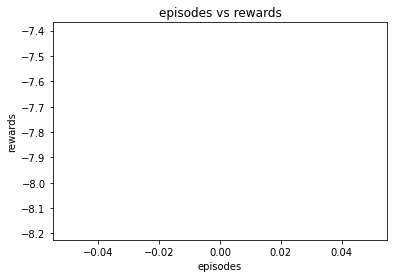

episode: 1 agent1_reward: -4.506442105685696 agent2_reward -4.506442105685696
episode: 2 agent1_reward: -4.633702477333455 agent2_reward -4.633702477333455
episode: 3 agent1_reward: -4.340999919323615 agent2_reward -4.340999919323615
episode: 4 agent1_reward: -4.231049921212243 agent2_reward -4.231049921212243
episode: 5 agent1_reward: -4.5105883671647655 agent2_reward -4.5105883671647655


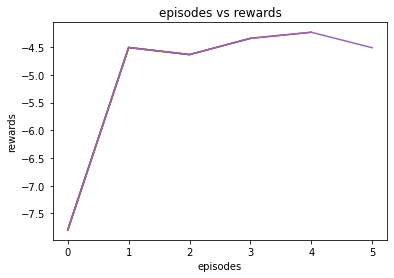

episode: 6 agent1_reward: -4.994277772547029 agent2_reward -4.994277772547029
episode: 7 agent1_reward: -4.510476566602286 agent2_reward -4.510476566602286
episode: 8 agent1_reward: -4.505227113786378 agent2_reward -4.505227113786378
episode: 9 agent1_reward: -4.625947308811197 agent2_reward -4.625947308811197
episode: 10 agent1_reward: -4.583774149176944 agent2_reward -4.583774149176944


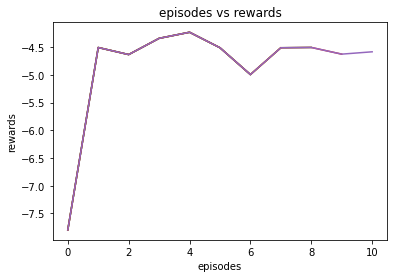

episode: 11 agent1_reward: -4.265509248655488 agent2_reward -4.265509248655488
episode: 12 agent1_reward: -4.2049204641612565 agent2_reward -4.2049204641612565
episode: 13 agent1_reward: -4.139470424077854 agent2_reward -4.139470424077854
episode: 14 agent1_reward: -4.0675368217381545 agent2_reward -4.0675368217381545
episode: 15 agent1_reward: -4.001020938397398 agent2_reward -4.001020938397398


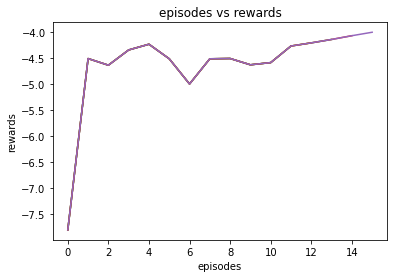

episode: 16 agent1_reward: -3.8897366548838295 agent2_reward -3.8897366548838295
episode: 17 agent1_reward: -3.857235705750003 agent2_reward -3.857235705750003
episode: 18 agent1_reward: -3.9486374975789844 agent2_reward -3.9486374975789844
episode: 19 agent1_reward: -3.908303512352256 agent2_reward -3.908303512352256
episode: 20 agent1_reward: -3.9097162081624584 agent2_reward -3.9097162081624584


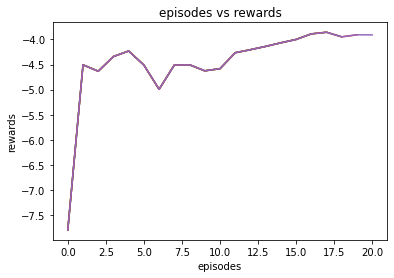

episode: 21 agent1_reward: -3.865190512601816 agent2_reward -3.865190512601816
episode: 22 agent1_reward: -3.713696151054627 agent2_reward -3.713696151054627
episode: 23 agent1_reward: -3.617543635072168 agent2_reward -3.617543635072168
episode: 24 agent1_reward: -3.5781315612645312 agent2_reward -3.5781315612645312
episode: 25 agent1_reward: -3.4911457563730215 agent2_reward -3.4911457563730215


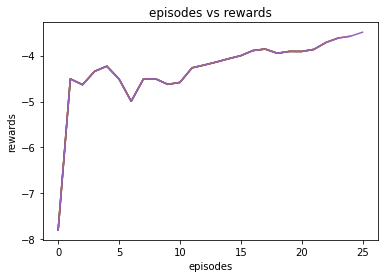

episode: 26 agent1_reward: -3.4298202034813863 agent2_reward -3.4298202034813863
episode: 27 agent1_reward: -3.3496931402992836 agent2_reward -3.3496931402992836
episode: 28 agent1_reward: -3.4091323278266064 agent2_reward -3.4091323278266064
episode: 29 agent1_reward: -3.363011752121066 agent2_reward -3.363011752121066
episode: 30 agent1_reward: -3.565697952652409 agent2_reward -3.565697952652409


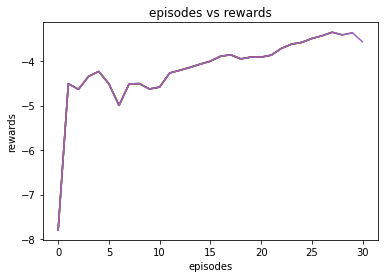

episode: 31 agent1_reward: -3.573239555239453 agent2_reward -3.573239555239453
episode: 32 agent1_reward: -3.503270884981718 agent2_reward -3.503270884981718
episode: 33 agent1_reward: -3.5350679472020823 agent2_reward -3.5350679472020823
episode: 34 agent1_reward: -3.493553122764519 agent2_reward -3.493553122764519
episode: 35 agent1_reward: -3.460897067547436 agent2_reward -3.460897067547436


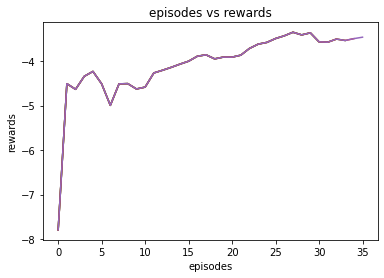

episode: 36 agent1_reward: -3.4601720542237957 agent2_reward -3.4601720542237957
episode: 37 agent1_reward: -3.39289016320953 agent2_reward -3.39289016320953
episode: 38 agent1_reward: -3.421751915082337 agent2_reward -3.421751915082337
episode: 39 agent1_reward: -3.3844619454929603 agent2_reward -3.3844619454929603
episode: 40 agent1_reward: -3.338098489321505 agent2_reward -3.338098489321505


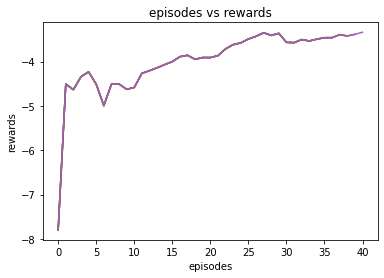

episode: 41 agent1_reward: -3.2803284325877526 agent2_reward -3.2803284325877526
episode: 42 agent1_reward: -3.2234865708867315 agent2_reward -3.2234865708867315
episode: 43 agent1_reward: -3.348286871614632 agent2_reward -3.348286871614632
episode: 44 agent1_reward: -3.3132982502014725 agent2_reward -3.3132982502014725
episode: 45 agent1_reward: -3.4000871254207765 agent2_reward -3.4000871254207765


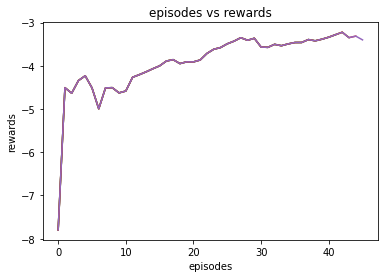

episode: 46 agent1_reward: -3.353868137437685 agent2_reward -3.353868137437685
episode: 47 agent1_reward: -3.3576284503012332 agent2_reward -3.3576284503012332
episode: 48 agent1_reward: -3.3566343799120073 agent2_reward -3.3566343799120073
episode: 49 agent1_reward: -3.4180739836516185 agent2_reward -3.4180739836516185
episode: 50 agent1_reward: -3.3749329784911954 agent2_reward -3.3749329784911954


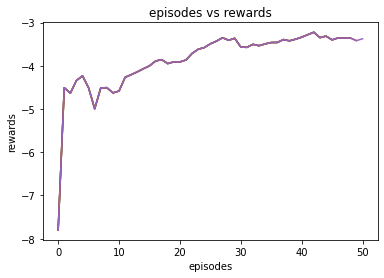

episode: 51 agent1_reward: -3.374187526811772 agent2_reward -3.374187526811772
episode: 52 agent1_reward: -3.3198716896355562 agent2_reward -3.3198716896355562
episode: 53 agent1_reward: -3.312673169298154 agent2_reward -3.312673169298154
episode: 54 agent1_reward: -3.300098391519833 agent2_reward -3.300098391519833
episode: 55 agent1_reward: -3.3425369116309605 agent2_reward -3.3425369116309605


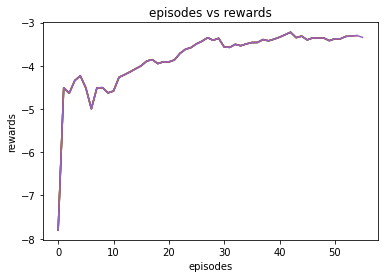

episode: 56 agent1_reward: -3.3286155295988378 agent2_reward -3.3286155295988378
episode: 57 agent1_reward: -3.3602157964270667 agent2_reward -3.3602157964270667
episode: 58 agent1_reward: -3.3773142430782648 agent2_reward -3.3773142430782648
episode: 59 agent1_reward: -3.457816063789319 agent2_reward -3.457816063789319
episode: 60 agent1_reward: -3.435320036607861 agent2_reward -3.435320036607861


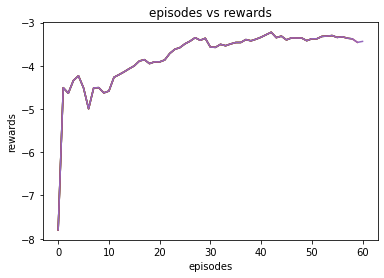

episode: 61 agent1_reward: -3.446111782238086 agent2_reward -3.446111782238086
episode: 62 agent1_reward: -3.4802110262941452 agent2_reward -3.4802110262941452
episode: 63 agent1_reward: -3.551216704790684 agent2_reward -3.551216704790684


In [ ]:
buffer = Buffer()
a = Mappo(21,5,2,2,100,200,buffer)
a.run()

In [12]:
mkdir memory

In [ ]:
pip install pickle-mixin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=6008 sha256=a1a573fe44ade6d97b933e721694daf35d542a6285cbb6e937df4cbfb6e58b79
  Stored in directory: /root/.cache/pip/wheels/d0/70/0b/673e09a7ed429660d22352a1b117b4f616a8fc054bdd7eb157
Successfully built pickle-mixin


In [ ]:
import pickle as p
import os

In [ ]:

d = [1,2,3,45,6]

In [ ]:
p.dump(d,open("kk/reward.bat","wb"))

In [ ]:
buffer.agent1_mean[0]

In [ ]:
ls

kk/  kk.cc.csv  kk.reward.bat


In [ ]:
import csv

In [ ]:
with open("kk/cc.csv" , "w") as f1:
  write = csv.writer(f1)
  for i in range(len(buffer.agent1_mean)):
    write.writerow([buffer.agent1_mean[i],buffer.agent2_mean[i]])

In [ ]:
li = ["sln0","agent1_reward","agent2_reward","agent1_loss","agent2_loss","agent1_value","agent2_value","agent1_return","agent2_returns","centeral_value","central_loss"]

In [ ]:
len(li)

In [ ]:
st_line = ["slno","agent1_reward","agent2_reward","agent1_loss","agent2_loss","agent1_value","agent2_value","agent1_return","agent2_returns","agent1_log_prob","agent2_log_prob","agent1_next_log_prob","agent2_next_log_prob","centeral_value","central_loss"]

In [ ]:
len(st_line)

15